# Topic modeling

The [topicmod module](api.rst#module-tmtoolkit.topicmod) offers a wide range of tools to facilitate [topic modeling](https://cacm.acm.org/magazines/2012/4/147361-probabilistic-topic-models/fulltext) with Python. This chapter will introduce the following techniques: 

TODO (link this)

- [parallel topic model computation for different copora and/or parameter sets](#Computing-topic-models-in-parallel)
- [evaluation of topic models (including finding a good number of topics for the given dataset)](#Evaluation-of-topic-models)
- common statistics for topic models
- export of topic models and summaries to different file formats
- visualization of topic models

A quick note on terminology: So far, we spoke about *tokens* or sometimes *terms* when we meant the individual elements that our documents consist of after we applied text preprocessing such as *tokenization* to the raw input text strings. These tokens can be lexicographically correct words, but they don't have to, e.g. when you applied stemming you might have tokens like "argu" in your vocabulary. There may also be numbers or punctuation symbols in your vocabulary. For many traditional topic modeling techniques, the results are usually two probability distributions: a *document-topic distribution* and a *topic-word distribution*. Since the latter is called topic-*word* and not topic-*token* or *-term* distribution, we will also use the term *word* when we mean any token from the corpus' vocabulary.


## An example document-term matrix

tmtoolkit supports topic models that are computed from document-term matrices (DTMs). Just as in the previous chapter, we will at first generate a DTM. However, this time the sample will be bigger:

In [1]:
import random
random.seed(20191120)   # to make the sampling reproducible

import numpy as np
np.set_printoptions(precision=5)

from tmtoolkit.corpus import Corpus

corpus = Corpus.from_builtin_corpus('english-NewsArticles').sample(100)

We will also now generate two DTMs, because we later want to show how you can compute topic models for two different DTMs in parallel. At first, we to some general preprocessing:

In [2]:
from tmtoolkit.preprocess import TMPreproc

preproc = TMPreproc(corpus)
preproc.pos_tag() \
    .lemmatize() \
    .tokens_to_lowercase() \
    .remove_special_chars_in_tokens()

<TMPreproc [100 documents]>

Now we at first apply more "relaxed" cleaning:

In [3]:
preproc_bigger = preproc.copy() \
    .add_stopwords(['would', 'could', 'mr', 'mrs', 'also']) \
    .clean_tokens(remove_shorter_than=2) \
    .remove_common_tokens(df_threshold=0.85) \
    .remove_uncommon_tokens(df_threshold=0.05)

preproc_bigger.n_docs, preproc_bigger.vocabulary_size

(100, 841)

Another copy of `preproc` will apply more aggressive cleaning and hence in a smaller vocabulary size:

In [4]:
preproc_smaller = preproc.copy() \
    .filter_for_pos('N') \
    .clean_tokens(remove_numbers=True, remove_shorter_than=2) \
    .remove_common_tokens(df_threshold=0.9) \
    .remove_uncommon_tokens(df_threshold=0.1)

del preproc

preproc_smaller.n_docs, preproc_smaller.vocabulary_size

(100, 149)

We will create the document labels, vocabulary arrays and DTMs for both versions now:

In [5]:
# doc_labels are the same for both

doc_labels = np.array(preproc_bigger.doc_labels)
doc_labels[:10]

array(['NewsArticles-1032', 'NewsArticles-1036', 'NewsArticles-104',
       'NewsArticles-1043', 'NewsArticles-1048', 'NewsArticles-1090',
       'NewsArticles-1126', 'NewsArticles-113', 'NewsArticles-1137',
       'NewsArticles-1141'], dtype='<U17')

In [6]:
vocab_bg = np.array(preproc_bigger.vocabulary)
vocab_sm = np.array(preproc_smaller.vocabulary) 

In [7]:
dtm_bg = preproc_bigger.dtm
dtm_sm = preproc_smaller.dtm

del preproc_bigger, preproc_smaller  # don't need these any more

dtm_bg, dtm_sm

(<100x841 sparse matrix of type '<class 'numpy.int32'>'
 	with 10116 stored elements in Compressed Sparse Row format>,
 <100x149 sparse matrix of type '<class 'numpy.int32'>'
 	with 2482 stored elements in Compressed Sparse Row format>)

We now have two sparse DTMs `dtm_bg` (from the bigger preprocessed data) and `dtm_sm` (from the smaller preprocessed data), a list of document labels `doc_labels` that represent the rows of both DTMs and vocabulary arrays `vocab_bg` and `vocab_sm` that represent the columns of the respective DTMs. We will use this data for the remainder of the chapter.

## Computing topic models in parallel

tmtoolkit allows to compute topic models in parallel, making use of all processor cores in your machine. Parallelization can be done per input DTM, per hyperparameter set and as combination of both. Hyperparameters control the number of topics and their "granularity". We will later have a look at the role of hyperparameters and how to find an optimal combination for a given dataset with the means of topic model evaluation.

For now, we will concentrate on computing the topic models for both of our two DTMs in parallel. tmtoolkit supports three very popular packages for topic modeling, which provide the work of actually computing the model from the input matrix. They can all be accessed in separate sub-modules of the [topicmod module](api.rst#module-tmtoolkit.topicmod):

- [topicmod.tm_lda](api.html#module-tmtoolkit.topicmod.tm_lda) provides an interface for the [lda](https://lda.readthedocs.io/en/latest/) package
- [topicmod.tm_sklearn](api.html#module-tmtoolkit.topicmod.tm_sklearn) provides an interface for the [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) package
- [topicmod.tm_gensim](api.html#module-tmtoolkit.topicmod.tm_gensim) provides an interface for the [Gensim](https://radimrehurek.com/gensim/) package

Each of these sub-modules offer at least two functions that work with the respective package: `compute_models_parallel()` for general parallel model computation and `evaluate_topic_models()` for parallel model computation and evaluation (discussed later). For now, we want to compute two models in parallel with the [lda](https://lda.readthedocs.io/en/latest/) package and hence use [compute_models_parallel()](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) from [topicmod.tm_lda](api.html#module-tmtoolkit.topicmod.tm_lda).

We need to provide two things for this function: First, the input matrices as a dict that maps labels to the respective DTMs. Second, hyperparameters to use for the model computations. Note that each topic modeling package has different hyperparameters and you should refer to their documentation in order to find out, which hyperparameters you can provide. For lda, we set the number of topics `n_topics` to 10 and the number of iterations for the Gibbs sampling process `n_iter` to 1000. We always want to use the same hyperparameters, so we pass these as `constant_parameters`. If we wanted to create models for a whole range of parameters, e.g. for different numbers of topics, we could provide `varying_parameters`. We will check this out later when we evaluate topic models.

<div class="alert alert-info">
    
Note that for proper topic modeling, we shouldn't just set the number of topics, but try to find it out via evaluation methods. We should also check if the algorithm converged using the provided likelihood estimations. We will do both later on, but now focus on `compute_models_parallel()`.

</div>

In [8]:
import logging
import warnings
from tmtoolkit.topicmod.tm_lda import compute_models_parallel

# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

# set data to use
dtms = {
    'bigger': dtm_bg,
    'smaller': dtm_sm
}

# and fixed hyperparameters
lda_params = {
    'n_topics': 10,
    'n_iter': 1000,
    'random_state': 20191122  # to make results reproducible
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)
models

defaultdict(list,
            {'smaller': [({'n_topics': 10,
                'n_iter': 1000,
                'random_state': 20191122},
               <lda.lda.LDA at 0x7fd3fed8fdd8>)],
             'bigger': [({'n_topics': 10,
                'n_iter': 1000,
                'random_state': 20191122},
               <lda.lda.LDA at 0x7fd3fed8fe80>)]})

As expected, two models were created. These can be accessed via the labels that we used to define the `dtm` dict:

In [9]:
models['smaller']

[({'n_topics': 10, 'n_iter': 1000, 'random_state': 20191122},
  <lda.lda.LDA at 0x7fd3fed8fdd8>)]

We can see that for each input DTM, we get a list of 2-tuples. The first element in each tuple is a dict that represents the hyperparameters that were used to compute the model, the second element is actual topic model (the `<lda.lda.LDA ...>` object). This structure looks a bit complex, but this is because it also supports varying parameters. Since we only have one fixed set of hyperparameters per DTM, we only have a list of length 1 for each DTM.

We will now access the models and print the top words per topic by using [print_ldamodel_topic_words()](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_topic_words):

In [10]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words

model_sm = models['smaller'][0][1]
print_ldamodel_topic_words(model_sm.topic_word_, vocab_sm, top_n=3)

topic_1
> #1. china (0.227017)
> #2. company (0.138742)
> #3. market (0.116043)
topic_2
> #1. election (0.149207)
> #2. mr (0.146679)
> #3. office (0.065767)
topic_3
> #1. report (0.111649)
> #2. minister (0.072578)
> #3. president (0.063276)
topic_4
> #1. percent (0.165212)
> #2. information (0.096987)
> #3. way (0.086215)
topic_5
> #1. police (0.085834)
> #2. attack (0.062561)
> #3. people (0.049470)
topic_6
> #1. us (0.102239)
> #2. russia (0.088738)
> #3. syria (0.071380)
topic_7
> #1. trump (0.198323)
> #2. house (0.109558)
> #3. president (0.096338)
topic_8
> #1. year (0.118300)
> #2. people (0.098987)
> #3. time (0.088124)
topic_9
> #1. party (0.122813)
> #2. germany (0.115729)
> #3. leader (0.077948)
topic_10
> #1. country (0.204228)
> #2. world (0.120143)
> #3. people (0.094116)


In [11]:
model_bg = models['bigger'][0][1]
print_ldamodel_topic_words(model_bg.topic_word_, vocab_bg, top_n=3)

topic_1
> #1. country (0.057972)
> #2. people (0.043669)
> #3. american (0.033883)
topic_2
> #1. leave (0.023419)
> #2. government (0.020610)
> #3. support (0.020141)
topic_3
> #1. police (0.037319)
> #2. report (0.031989)
> #3. attack (0.029027)
topic_4
> #1. russian (0.061027)
> #2. russia (0.049933)
> #3. force (0.042167)
topic_5
> #1. first (0.048892)
> #2. new (0.035923)
> #3. run (0.023952)
topic_6
> #1. one (0.032946)
> #2. year (0.030310)
> #3. people (0.026094)
topic_7
> #1. china (0.060271)
> #2. company (0.045540)
> #3. market (0.030809)
topic_8
> #1. trump (0.071561)
> #2. president (0.057932)
> #3. house (0.036806)
topic_9
> #1. election (0.057945)
> #2. party (0.056106)
> #3. vote (0.045990)
topic_10
> #1. get (0.027070)
> #2. day (0.023089)
> #3. make (0.022691)


We could also generate models from different parameters in parallel, either for a single DTM or several. In the following example we generate models for a series of four different values for the `alpha` parameter. The parameters `n_iter` and `n_topics` are held constant across all models.

In [12]:
var_params = [{'alpha': 1/(10**x)} for x in range(1, 5)]

const_params = {
    'n_iter': 500,
    'n_topics': 10,
    'random_state': 20191122  # to make results reproducible
}

models = compute_models_parallel(dtm_sm,  # smaller DTM
                                 varying_parameters=var_params,
                                 constant_parameters=const_params)
models

[({'alpha': 0.01, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7fd3fed8fe48>),
 ({'alpha': 0.0001, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7fd3fed83f28>),
 ({'alpha': 0.001, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7fd3fed7f2e8>),
 ({'alpha': 0.1, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7fd3fc265278>)]

We could compare these models now, e.g. by investigating their topics.

A more systematic approach on comparing and evaluating topic models, also in order to find an good set of hyperparameters for a given dataset, will be presented in the next section.

## Evaluation of topic models

tmtoolkit provides several metrics for comparing and evaluating topic models. This can be used for finding a good hyperparameter set for a given dataset, e.g. a good combination of the number of topics and concentration paramaters (often called alpha and beta in literature). For some background on hyperparameters in topic modeling, see [this blog post](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/).

For each candidate hyperparameter set, a model can be generated and evaluated in parallel. We will do this now for the "big" DTM `dtm_bg`. Our candidate values for the number of topics `k` range between 20 and 120, with steps of 10. We make the concentration parameter for a prior over the document-specific topic distributions, alpha, depending on `k` as `1/k`:

In [13]:
var_params = [{'n_topics': k, 'alpha': 1/k} for k in range(20, 121, 10)]
var_params

[{'n_topics': 20, 'alpha': 0.05},
 {'n_topics': 30, 'alpha': 0.03333333333333333},
 {'n_topics': 40, 'alpha': 0.025},
 {'n_topics': 50, 'alpha': 0.02},
 {'n_topics': 60, 'alpha': 0.016666666666666666},
 {'n_topics': 70, 'alpha': 0.014285714285714285},
 {'n_topics': 80, 'alpha': 0.0125},
 {'n_topics': 90, 'alpha': 0.011111111111111112},
 {'n_topics': 100, 'alpha': 0.01},
 {'n_topics': 110, 'alpha': 0.00909090909090909},
 {'n_topics': 120, 'alpha': 0.008333333333333333}]

The heart of the model evaluation process is the function [evaluate_topic_models()](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models), which is available for all three topic modeling packages. We stick with lda and import that function from [topicmod.tm_lda](api.html#module-tmtoolkit.topicmod.tm_lda). It is similar to [compute_models_parallel()](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) as it accepts varying and constant hyperparameters. However, it doesn't only compute the models in parallel, but also applies several metrics to these models in order to evaluate them. This can be controlled with the `metric` parameter that accepts a string or a list of strings that specify the used metric(s). These metrics refer to functions that are implemented in [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate).

Each topic modeling sub-module defines two important sequences: `AVAILABLE_METRICS` and `DEFAULT_METRICS`. The former lists all available metrics for that sub-module, the latter lists the default metrics that are used when you don't specify something with the `metric` parameter. Let's have a look at both sequences in [topicmod.tm_lda](api.html#module-tmtoolkit.topicmod.tm_lda):

In [14]:
from tmtoolkit.topicmod import tm_lda

tm_lda.AVAILABLE_METRICS

('loglikelihood',
 'cao_juan_2009',
 'arun_2010',
 'coherence_mimno_2011',
 'griffiths_2004',
 'held_out_documents_wallach09',
 'coherence_gensim_u_mass',
 'coherence_gensim_c_v',
 'coherence_gensim_c_uci',
 'coherence_gensim_c_npmi')

In [15]:
tm_lda.DEFAULT_METRICS

('cao_juan_2009', 'arun_2010', 'coherence_mimno_2011')

For details about the metrics and the academic references, see the respective implementations in the [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate) module.

We will now run the model evaluations with [evaluate_topic_models()](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models) using our previously generated list of varying hyperparameters `var_params`, some constant hyperparameters and the default set of metrics. We also set `return_models=True` which says to retain the generated models in the evaluation results:

In [16]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 1000,
    'eta': 0.1,       # "eta" aka "beta"
    'random_state': 20191122  # to make results reproducible
}

eval_results = evaluate_topic_models(dtm_bg,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     return_models=True)
eval_results[:3]  # only show first three models

[({'n_topics': 20,
   'alpha': 0.05,
   'n_iter': 1000,
   'eta': 0.1,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fd3fe3f5e80>,
   'cao_juan_2009': 0.12558836629807552,
   'arun_2010': 7.403579405167859,
   'coherence_mimno_2011': -1.4655146068866647}),
 ({'n_topics': 30,
   'alpha': 0.03333333333333333,
   'n_iter': 1000,
   'eta': 0.1,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fd3fe306898>,
   'cao_juan_2009': 0.10850811387586812,
   'arun_2010': 4.216179012713291,
   'coherence_mimno_2011': -1.6427312298716041}),
 ({'n_topics': 40,
   'alpha': 0.025,
   'n_iter': 1000,
   'eta': 0.1,
   'random_state': 20191122},
  {'model': <lda.lda.LDA at 0x7fd3fe3069b0>,
   'cao_juan_2009': 0.1102660561003882,
   'arun_2010': 3.7261104251741655,
   'coherence_mimno_2011': -1.683373430872738})]

The evaluation results are a list with pairs of hyperparameters and their evaluation results for each metric. Additionally, there is the generated model for each hyperparameter set.

We now use [results_by_parameter()](api.rst#tmtoolkit.topicmod.evaluate.results_by_parameter), which takes the "raw" evaluation results and sorts them by a specific hyperparameter, in this case `n_topics`. This is important because this is the way that the function for visualizing evaluation results, [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results), expects the input.

In [17]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]  # again only the first three models

[(20,
  {'model': <lda.lda.LDA at 0x7fd3fe3f5e80>,
   'cao_juan_2009': 0.12558836629807552,
   'arun_2010': 7.403579405167859,
   'coherence_mimno_2011': -1.4655146068866647}),
 (30,
  {'model': <lda.lda.LDA at 0x7fd3fe306898>,
   'cao_juan_2009': 0.10850811387586812,
   'arun_2010': 4.216179012713291,
   'coherence_mimno_2011': -1.6427312298716041}),
 (40,
  {'model': <lda.lda.LDA at 0x7fd3fe3069b0>,
   'cao_juan_2009': 0.1102660561003882,
   'arun_2010': 3.7261104251741655,
   'coherence_mimno_2011': -1.683373430872738})]

We can now see the results for each metric across the specified range of number of topics using [plot_eval_results()](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results):

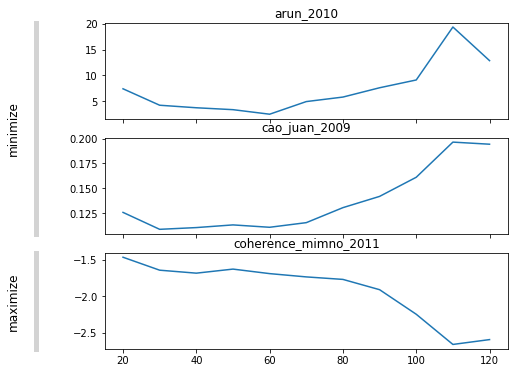

In [18]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_topics);

These results suggest to set the number of topics, `n_topics`, to 40 and alpha to `0.025`. We don't have to generate a model with these hyperparameters again, because it's already in the evaluation results (thanks to `return_models=True`). We extract the model from there in order to use it in the rest of the chapter.

In [19]:
best_tm = [m for k, m in eval_results_by_topics if k == 40][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta  # just to make sure

(40, 0.025, 0.1)

## Common statistics for topic models

The [topicmod.model_stats](api.rst#module-tmtoolkit.topicmod.model_stats) module mostly contains functions that compute statistics from the document-topic and topic-word distribution of a topic model and also some helper functions for working with such distributions. We'll start with an important helper function, [generate_topic_labels_from_top_words()]((api.rst#tmtoolkit.topicmod.model_stats.generate_topic_labels_from_top_words)).

In topic modeling, topics are numbered because they're *abstract* – they're simply a probability distribution across all words in the vocabulary. Still, it's useful to give them labels for better identification. The function [generate_topic_labels_from_top_words()](api.rst#tmtoolkit.topicmod.model_stats.generate_topic_labels_from_top_words) is very useful for that, as it finds labels according to the most "relevant" words in each topic. We'll later see how we can identify the most relevant words per topic using a special relevancy statistic. Note that you can adjust the weight of the relevancy measure for the ranking by using the parameter `lambda_` which is in range $[0, 1]$.

The function requires at least the topic-word and document-topic distributions from the model, the document lengths and the vocabulary. It then finds the minimum number of relevant words that uniquely label each topic. You can also use a fixed number for that minimum number with the parameter `n_words`.

In [20]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

doc_lengths_bg = doc_lengths(dtm_bg)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_lengths_bg,
    vocab_bg,
    lambda_=0.6
)

topic_labels[:5]   # showing only the first 5 topics here

array(['1_club_line', '2_germany_german', '3_rule_circumstance',
       '4_parent_child', '5_report_committee'], dtype='<U28')

As we can see, two words are necessary to label each topic uniquely. By default, each label is prefixed with a number. You can change that with the parameter `labels_format`.

Let's have a look at the top words for a specific topic. We can use [ldamodel_top_topic_words()](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) for that from the module [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io), which we will have a closer look at later:

In [21]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(best_tm.topic_word_,
                                          vocab_bg,
                                          row_labels=topic_labels)
top_topic_word[top_topic_word.index == '8_intelligence_investigation']

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
8_intelligence_investigation,election (0.04789),investigation (0.04509),intelligence (0.04229),committee (0.03948),presidential (0.02828),public (0.02828),today (0.01708),go (0.01708),put (0.01708),campaign (0.01708)


We'll now focus on the marginal topic and word distributions. Let's get the marginal topic distribution first by using [marginal_topic_distrib()](api.rst#tmtoolkit.topicmod.model_stats.marginal_topic_distrib):

In [22]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(best_tm.doc_topic_, doc_lengths_bg)
marg_topic

array([0.01915, 0.02381, 0.00955, 0.02086, 0.02065, 0.0191 , 0.04533,
       0.01579, 0.01612, 0.02299, 0.01582, 0.0143 , 0.02747, 0.03418,
       0.03532, 0.0213 , 0.04032, 0.13373, 0.02681, 0.01679, 0.01693,
       0.02254, 0.01597, 0.01937, 0.02505, 0.02165, 0.03339, 0.02191,
       0.01859, 0.02687, 0.03016, 0.0117 , 0.01347, 0.02801, 0.02691,
       0.02085, 0.01505, 0.0257 , 0.01226, 0.01426])

The marginal topic distribution can be interpreted as the "importance" of each topic for the whole corpus. Let's get the sorted indices into `topic_labels` with `np.argsort()` and get the top five topics:

In [23]:
# np.argsort() gives ascending order, hence reverse via [::-1]
topic_labels[np.argsort(marg_topic)[::-1][:5]]

array(['18_one_year', '7_america_american', '17_trump_white',
       '15_party_election', '14_term_minister'], dtype='<U28')

Likewise, we can get the marginal word distribution with [marginal_word_distrib()](api.rst#tmtoolkit.topicmod.model_stats.marginal_word_distrib) from the model's topic-word distribution and the marginal topic distribution. We'll use this to list the most probable words for the corpus. As expected, these are mostly quite common words:

In [24]:
from tmtoolkit.topicmod.model_stats import marginal_word_distrib

marg_word = marginal_word_distrib(best_tm.topic_word_, marg_topic)
vocab_bg[np.argsort(marg_word)[::-1][:10]]

array(['people', 'year', 'one', 'make', 'new', 'country', 'us', 'time',
       'trump', 'report'], dtype='<U14')